<a href="https://colab.research.google.com/github/Prasang-Biyani/machine-translation/blob/main/Seq2SeqImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='red'>**Sequence to sequence implementation**</font>

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Seq2Seq

Mounted at /content/drive
/content/drive/My Drive/Seq2Seq


In [ ]:
# !wget http://www.manythings.org/anki/ita-eng.zip
# !unzip *.zip
# !wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

<font color='green'>**Load the data**</font>

In [ ]:
with open("ita.txt", 'r') as f:
  text = f.readlines()

<font color='green'>**Preprocess data**</font>

In [ ]:
import pandas as pd
import numpy as np

# decoder_ip = []
# decoder_op = []
# encoder = []

# english = []
# italian = []

# for txt in text:
#   char_1, char_2 = txt.split('\t')[:2]
#   english.append(char_1)
#   italian.append(char_2)


# decoder_ip = ["<start> " + eng for eng in english]
# encoder = ["<start> " + ita + " <end>" for ita in italian]
# decoder_op = [eng + " <end>" for eng in english]


# df = pd.DataFrame(data={
#     "italian": italian,
#     "english": english,
#     "encoder": encoder,
#     "decoder_ip": decoder_ip,
#     "decoder_op": decoder_op
# })

# df.to_csv('preprocessed.csv', index=False)
df = pd.read_csv('preprocessed.csv')
max_words_encoder = max([len(sentence.split()) for sentence in df['encoder'].values])
max_words_decoder_ip = max([len(sentence.split()) for sentence in df['decoder_ip'].values])
max_words_decoder_op = max([len(sentence.split()) for sentence in df['decoder_op'].values])

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
%tensorflow_version 2.x
%load_ext tensorboard
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 14.3 MB/s 


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2, random_state=101)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
encoder_tokenizer = Tokenizer(filters='"#$%&()*+,-/:;=?@[\\]^`{|}~\t\n')
encoder_tokenizer.fit_on_texts(X_train['encoder'].values)

vocab_size_encoder = len(encoder_tokenizer.word_index) + 1

train_encoder_sequences = encoder_tokenizer.texts_to_sequences(X_train['encoder'].values)
test_encoder_sequences = encoder_tokenizer.texts_to_sequences(X_test['encoder'].values)

# padding sequences
train_encoder_padded = pad_sequences(train_encoder_sequences, padding='post', maxlen=max_words_encoder)
test_encoder_padded = pad_sequences(test_encoder_sequences, padding='post', maxlen=max_words_encoder)

In [ ]:
decoder_ip_tokenizer = Tokenizer(filters='"#$%&()*+,-/:;=?@[\\]^`{|}~\t\n')
decoder_ip_tokenizer.fit_on_texts(X_train['decoder_ip'].values)

vocab_size_decoder_ip = len(decoder_ip_tokenizer.word_index) + 1

train_decoder_ip_sequences = decoder_ip_tokenizer.texts_to_sequences(X_train['decoder_ip'].values)
test_decoder_ip_sequences = decoder_ip_tokenizer.texts_to_sequences(X_test['decoder_ip'].values)

#padding sequences
train_decoder_padded_ip= pad_sequences(train_decoder_ip_sequences, padding='post', maxlen=max_words_decoder_ip)
test_decoder_padded_ip = pad_sequences(test_decoder_ip_sequences, padding='post', maxlen=max_words_decoder_ip)

In [ ]:
decoder_op_tokenizer = Tokenizer(filters='"#$%&()*+,-/:;=?@[\\]^`{|}~\t\n')
decoder_op_tokenizer.fit_on_texts(X_train['decoder_op'].values)

vocab_size_decoder_op = len(decoder_op_tokenizer.word_index) + 1

train_decoder_op_sequences = decoder_op_tokenizer.texts_to_sequences(X_train['decoder_op'].values)
test_decoder_op_sequences = decoder_op_tokenizer.texts_to_sequences(X_test['decoder_op'].values)

#padding sequences
train_decoder_padded_op = pad_sequences(train_decoder_op_sequences, padding='post', maxlen=max_words_decoder_op)
test_decoder_padded_op = pad_sequences(test_decoder_op_sequences, padding='post', maxlen=max_words_decoder_op)

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_decoder_ip, 100))
for word, i in decoder_ip_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(19464, 100)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Flatten, concatenate, LSTM, Dropout, ConvLSTM1D, Conv1D
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import numpy as np

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs, encoder_final_state_h, encoder_final_state_c
    '''

    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):

        super().__init__()
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_size
        self.input_length = input_length
        self.lstm_units = lstm_size
        self.lstm_output = 0
        self.lstm_state_h = 0
        self.lstm_state_c = 0

        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder", trainable=True)
        self.lstm_encoder = LSTM(self.lstm_units, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self, input_sequence, states=[0, 0]):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embeddings = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm_encoder(input_embeddings)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c    

    
    def initialize_states(self, batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.lstm_output = np.zeros((batch_size, self.lstm_units))
      self.lstm_state_h = np.zeros((batch_size, self.lstm_units))
      self.lstm_state_c = np.zeros((batch_size, self.lstm_units))
      return self.lstm_state_h, self.lstm_state_c
      


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Decoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self, out_vocab_size, embedding_size, lstm_size, input_length):

        super().__init__()
        #Initialize Embedding layer
        #Intialize Decoder LSTM layer
        self.vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        if self.embedding_size == 100:
          self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", trainable=False, weights=[embedding_matrix])
        else:
          self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", trainable=True)

        self.lstm_decoder = LSTM(self.lstm_size, return_sequences=True, return_state=True, name="Decoder_LSTM")        


    def call(self, input_sequence, initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embedding = self.embedding(input_sequence)
        decoder_output, decoder_final_state_h, decoder_final_state_c  = self.lstm_decoder(target_embedding, initial_state=initial_states)
        return decoder_output, decoder_final_state_h, decoder_final_state_c

In [ ]:
class Encoder_Decoder(tf.keras.Model):
    
    def __init__(self, **params):
        super().__init__()
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'

        self.batch_size = params['BATCH_SIZE']
        self.embedding_size_encoder = params['embedding_size_encoder']
        self.embedding_size_decoder = params['embedding_size_decoder']
        self.encoder = Encoder(inp_vocab_size=vocab_size_encoder, embedding_size=self.embedding_size_encoder, lstm_size=lstm_size, input_length=max_words_encoder)
        self.decoder = Decoder(out_vocab_size=vocab_size_decoder_ip, embedding_size=self.embedding_size_decoder, lstm_size=lstm_size, input_length=max_words_decoder_ip)
        self.dense_layer = Dense(vocab_size_decoder_op, activation='softmax')
        self.initial_state = self.encoder.initialize_states(self.batch_size)
    
    def call(self, data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        params = dict()
        params['input_sequence'], params['output_sequence'] = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(params['input_sequence'], [self.initial_state])
        decoder_output, decoder_h, decoder_c = self.decoder(params['output_sequence'], [encoder_h, encoder_c])
        dense_output = self.dense_layer(decoder_output)
        # dense_output = self.time_distrbuted(dense_output)
        return dense_output        
        

In [ ]:
tf.keras.backend.clear_session()

import os
import datetime

logdir = os.path.join("vanilla_encoder_decoder_tensorboard_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

lstm_size=256

# Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model = Encoder_Decoder(BATCH_SIZE=32, embedding_size_encoder=50, embedding_size_decoder=100)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
!rm -rf vanilla_encoder_decoder_tensorboard_logs
model.fit([train_encoder_padded, train_decoder_padded_ip], train_decoder_padded_op, epochs=10, batch_size=512, 
          validation_data=([test_encoder_padded, test_decoder_padded_ip], test_decoder_padded_op), callbacks=[tensorboard_callback])

Epoch 1/10
552/552 [==============================] - 136s 236ms/step - loss: 0.3404 - val_loss: 0.2947
Epoch 2/10
552/552 [==============================] - 126s 229ms/step - loss: 0.2699 - val_loss: 0.2413
Epoch 3/10
552/552 [==============================] - 126s 229ms/step - loss: 0.2197 - val_loss: 0.1991
Epoch 4/10
552/552 [==============================] - 126s 229ms/step - loss: 0.1829 - val_loss: 0.1713
Epoch 5/10
552/552 [==============================] - 126s 229ms/step - loss: 0.1556 - val_loss: 0.1486
Epoch 6/10
552/552 [==============================] - 126s 229ms/step - loss: 0.1333 - val_loss: 0.1304
Epoch 7/10
552/552 [==============================] - 126s 229ms/step - loss: 0.1151 - val_loss: 0.1165
Epoch 8/10
552/552 [==============================] - 126s 229ms/step - loss: 0.1001 - val_loss: 0.1060
Epoch 9/10
552/552 [==============================] - 126s 229ms/step - loss: 0.0877 - val_loss: 0.0959
Epoch 10/10
552/552 [==============================] - 126s 229m

In [ ]:
# plot tensorboard graphs

In [ ]:
from tqdm import tqdm
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''
  encoder_outputs, encoder_h, encoder_c = model.layers[0](np.expand_dims(input_sentence, 0))
  states = [encoder_h, encoder_c]
  curr_vector = np.full((1, 1), encoder_tokenizer.word_index['<start>'])
  prediction = []
  for i in range(test_decoder_padded_ip.shape[1]):
    curr_embedding = model.layers[1].embedding(curr_vector)
    decoder_output, decoder_h, decoder_c = model.layers[1].lstm_decoder(curr_embedding, states)
    states = [decoder_h, decoder_c]
    output = model.layers[2](decoder_output)
    curr_vector = np.reshape(np.argmax(output), (1, 1))
    if curr_vector[0] == decoder_op_tokenizer.word_index['<end>']:
      break
    prediction.append(curr_vector[0][0])
  predicted_word = [decoder_op_tokenizer.index_word[pred] for pred in prediction]
  return predicted_word

In [ ]:
np.random.seed(101)
indexes = np.random.permutation(1000)
predicted_thousand_sentences = [" ".join(predict(test_encoder_padded[index])) for index in indexes]
original_thousand_sentences = [X_test['english'].iloc[index] for index in indexes]

In [ ]:
original_thousand_sentences[0], predicted_thousand_sentences[0]

("We're unusual.", "we're unusual.")

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
avg_bleu = sum([bleu.sentence_bleu(reference, translated) for reference, translated in zip(original_thousand_sentences, predicted_thousand_sentences)]) / 1000
print(avg_bleu)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.8293736751504862


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention 
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_size
        self.lstm_units = lstm_size
        self.input_length = input_length
        self.lstm_output = 0
        self.lstm_state_h = 0
        self.lstm_state_c = 0

        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, trainable=True)
        self.lstm = LSTM(self.lstm_units, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self, input_sequence, states=[0, 0]):

      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      input_embeddings = self.embedding(input_sequence)
      self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm(input_embeddings)
      return self.lstm_output, self.lstm_state_h, self.lstm_state_c   
    
    def initialize_states(self, batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.lstm_output = np.zeros((batch_size, self.lstm_units))
      self.lstm_state_h = np.zeros((batch_size, self.lstm_units))
      self.lstm_state_c = np.zeros((batch_size, self.lstm_units))

      return self.lstm_state_h, self.lstm_state_c

<font color='blue'>**Attention**</font>

In [ ]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self, scoring_function, att_units):

    # Please go through the reference notebook and research paper to complete the scoring functions
    super(Attention, self).__init__()

    self.att_units = att_units
    self.scoring_function = scoring_function
    self.context = None
    self.attention_weights = None

    if self.scoring_function == 'dot':
      # Intialize variables needed for Dot score function here
      self.V = tf.keras.layers.Dense(1)
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.W = tf.keras.layers.Dense(self.att_units)
      self.V = tf.keras.layers.Dense(1)
    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.W1 = tf.keras.layers.Dense(self.att_units)
      self.W2 = tf.keras.layers.Dense(self.att_units)
      self.V = tf.keras.layers.Dense(1)
  
  def call(self, decoder_hidden_state, encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        score = []
        # expanding decoder_hidden_state at 2nd axis
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        # print(tf.keras.layers.Dot(axes=(1, 2))([encoder_output, tf.transpose(decoder_hidden_state)]).shape)
        for batch_id in range(encoder_output.shape[0]):
          # score.append(np.dot(encoder_output[batch_id, :,  :], decoder_hidden_state[batch_id, :, :].T))
          score.append(tf.tensordot(encoder_output[batch_id, :, :], tf.transpose(decoder_hidden_state[batch_id, :, :]), axes=1))
        # score shape == (batch_size, max_length, 1)
        self.attention_weights = self.V(tf.convert_to_tensor(score))
        # attention_weights shape == (batch_size, max_length, 1)
        self.attention_weights = tf.nn.softmax(self.attention_weights, axis=1)
        # # context_vector shape == (batch_size, att_units)
        self.context_vector = self.attention_weights * encoder_output
        self.context_vector = tf.reduce_sum(self.context_vector, axis=1)

        return self.context_vector, self.attention_weights

    elif self.scoring_function == 'general':
        # Implement General score function here
        # expanding decoder_hidden_state at 2nd axis
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        score = self.V(self.W(decoder_hidden_state) * encoder_output)
        self.attention_weights = tf.nn.softmax(score, axis=1)
        # attention_weights shape == (batch_size, max_length, 1)
        self.context_vector = self.attention_weights * encoder_output
        self.context_vector = tf.reduce_sum(self.context_vector, axis=1)

        return self.context_vector, self.attention_weights

    # https://blog.paperspace.com/seq-to-seq-attention-mechanism-keras/#step-7-attention-mechanism-class
    elif self.scoring_function == 'concat':
      # Implement General score function here
      decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
      # score shape == (batch_size, max_length, 1)
      score = self.V(tf.nn.tanh(
        self.W1(decoder_hidden_state) + self.W2(encoder_output)))
      # attention_weights shape == (batch_size, max_length, 1)
      self.attention_weights = tf.nn.softmax(score, axis=1)
      # context_vector shape after sum == (batch_size, hidden_size)
      self.context_vector = self.attention_weights * encoder_output
      self.context_vector = tf.reduce_sum(self.context_vector, axis=1)

      return self.context_vector, self.attention_weights

<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):

      super(One_Step_Decoder, self).__init__()
      self.att_units = att_units
      self.scoring_function = score_fun
      self.vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      # Initialize decoder embedding layer, LSTM and any other objects needed
      if self.embedding_dim == 100:
          self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", trainable=False, weights=[embedding_matrix])
      else:
          self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", trainable=True)
      # self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True)
      self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True)
      self.attention = Attention(self.scoring_function, self.att_units)
      # self.dense_1 = Dense(self.att_units)
      self.dense = Dense(self.vocab_size)

  def call(self, input_to_decoder, encoder_output, state_h, state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    target_embedding = self.embedding(input_to_decoder)
    context_vector, attention_weights = self.attention(state_h, encoder_output)
    concatenated = tf.concat([tf.expand_dims(context_vector, 1), target_embedding], axis=-1)
    decoder_output, decoder_h, decoder_c = self.lstm(concatenated)
    dense = self.dense(decoder_output)
    dense = tf.reshape(dense, (-1, dense.shape[2]))
    # dense_2 = self.dense_2(dense_1)
    # dense = tf.squeeze(dense)
    return dense, decoder_h, decoder_c, attention_weights, context_vector



<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super(Decoder, self).__init__()
      self.vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units

      self.one_step_decoder = One_Step_Decoder(self.vocab_size, self.embedding_dim, self.input_length,
                                               self.dec_units, self.score_fun, self.att_units)     
    
    @tf.function
    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state):
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        all_outputs = tf.TensorArray(tf.float32, size=input_to_decoder.shape[1], name='output_arrays')
        for time_step in range(input_to_decoder.shape[1]):
          output, decoder_hidden_state, _, _, _= self.one_step_decoder(input_to_decoder[:, time_step : time_step + 1], encoder_output, decoder_hidden_state, decoder_cell_state)
          # output, decoder_hidden_state, _, _, _= self.one_step_decoder(input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state)
          all_outputs = all_outputs.write(time_step, output)
        all_outputs = tf.transpose(all_outputs.stack(), [1, 0, 2])
        # print(all_outputs.shape)
        return all_outputs

<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, params):
    super(encoder_decoder, self).__init__()
    #Intialize objects from encoder decoder
    self.input_vocab_size = params['input_vocab_size']
    self.encoder_embedding_dim = params['encoder_embedding_dim']
    self.lstm_size = params['lstm_size']
    self.encoder_input_length = params['encoder_input_length']
    self.scoring_function = params['scoring_function']
    self.attention_units = params['attention_units']
    self.output_vocab_size = params['output_vocab_size']
    self.decoder_embedding_dim = params['decoder_embedding_dim']
    self.decoder_input_length = params['decoder_input_length']

    self.encoder = Encoder(inp_vocab_size=self.input_vocab_size, embedding_size=self.encoder_embedding_dim, 
                           lstm_size=self.lstm_size, input_length=self.encoder_input_length)
    
    self.decoder = Decoder(out_vocab_size=self.output_vocab_size, embedding_dim=self.decoder_embedding_dim, 
                           input_length=self.decoder_input_length,
                           dec_units=self.lstm_size, score_fun=self.scoring_function, att_units=self.attention_units)
  @tf.function
  def call(self, data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    encoder_ip, decoder_ip = data[0], data[1]
    encoder_output, encoder_h, encoder_c = self.encoder(encoder_ip)
    decoder_output = self.decoder(decoder_ip, encoder_output, encoder_h, encoder_c)
    return decoder_output



<font color='blue'>**Custom loss function**</font>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [ ]:
tf.keras.backend.clear_session()

import os
import datetime

logdir = os.path.join("attention_encoder_decoder_tensorboard_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.
params = dict()
params['input_vocab_size'] = vocab_size_encoder
params['encoder_embedding_dim'] = 100
params['lstm_size'] = 64
params['encoder_input_length'] = 20
params['scoring_function'] = 'dot'
params['attention_units'] = 64

params['output_vocab_size'] = vocab_size_decoder_ip
params['decoder_embedding_dim'] = 100
params['decoder_input_length'] = 20

model = encoder_decoder(params)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_function, run_eagerly=True)

In [ ]:
!rm -rf attention_encoder_decoder_tensorboard_logs
# validation_data=([test_encoder_padded, test_decoder_padded_ip], test_decoder_padded_op)
model.fit([train_encoder_padded, train_decoder_padded_ip], train_decoder_padded_op, epochs=10, batch_size=64,
          validation_data=([test_encoder_padded, test_decoder_padded_ip], test_decoder_padded_op),
          callbacks=[tensorboard_callback])

Epoch 1/10
4416/4416 [==============================] - 6885s 1s/step - loss: 0.3198 - val_loss: 0.2736
Epoch 2/10
4416/4416 [==============================] - 6275s 1s/step - loss: 0.2619 - val_loss: 0.2499
Epoch 3/10
4416/4416 [==============================] - 6261s 1s/step - loss: 0.2415 - val_loss: 0.2341
Epoch 4/10
4416/4416 [==============================] - 6239s 1s/step - loss: 0.2283 - val_loss: 0.2241
Epoch 5/10
4416/4416 [==============================] - 6185s 1s/step - loss: 0.2192 - val_loss: 0.2175
Epoch 6/10
4416/4416 [==============================] - 6125s 1s/step - loss: 0.2124 - val_loss: 0.2135
Epoch 7/10
4416/4416 [==============================] - 6127s 1s/step - loss: 0.2068 - val_loss: 0.2069
Epoch 8/10
4416/4416 [==============================] - 6128s 1s/step - loss: 0.2018 - val_loss: 0.2036
Epoch 9/10
4416/4416 [==============================] - 6085s 1s/step - loss: 0.1974 - val_loss: 0.1993
Epoch 10/10
4416/4416 [==============================] - 6120s 1

Dot-based attention:
1. It is the dot product between the encoder output states and the current decoder 
state.
2. The shape of encoder output states is (batch_size, input_length, lstm_units).
3. The shape of the decoder's current state is (batch_size, lstm_units).
4. A general rule of the dot product: #columns (first matrix) == #rows (second matrix).
5. We add another dimension at axis=1 in the current decoder state to make the dot product easier.
6. We are iterating through the #batches and storing them in a list.
7. Finally, we calculate attention weights after passing the list on the softmax function.
8. A context vector is calculated by the Sum Of Product (SOP) between encoder output states and attention weights.

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, actual_sentence, predicted_sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  
  predicted_sentence.append('<end>')
  attention = attention[:len(predicted_sentence), :len(actual_sentence)]
  
  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + actual_sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence, visualize_attention):
  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  encoder_output, encoder_h, encoder_c = model.layers[0](np.expand_dims(input_sentence, 0))
  actual_sentence = [encoder_tokenizer.index_word[token] for token in input_sentence if token != 0]
  states = [encoder_h, encoder_c]
  curr_vector = np.full((1, 1), encoder_tokenizer.word_index['<start>'])
  prediction = []
  attention_weights_lst = []
  for i in range(test_decoder_padded_ip.shape[1]):
    decoder_output, decoder_h, decoder_c, attention_weights, context_vector = model.layers[1].one_step_decoder(curr_vector, encoder_output, states[0], states[1])
    attention_weights_lst.append(attention_weights)
    states = [decoder_h, decoder_c]
    # output = model.layers[1](decoder_output)
    curr_vector = np.reshape(np.argmax(decoder_output), (1, 1))
    if curr_vector[0][0] == decoder_op_tokenizer.word_index['<end>']:
      break
    prediction.append(curr_vector[0][0])
  predicted_sentence = [decoder_op_tokenizer.index_word[pred] for pred in prediction]
  # call plot_attention
  if visualize_attention == True:
    attention_weights_numpy = np.squeeze(np.asarray(attention_weights_lst), axis=(1, 3))
    plot_attention(attention_weights_numpy, actual_sentence, predicted_sentence)
  return predicted_sentence

"what's your favorite color of the station <end>"

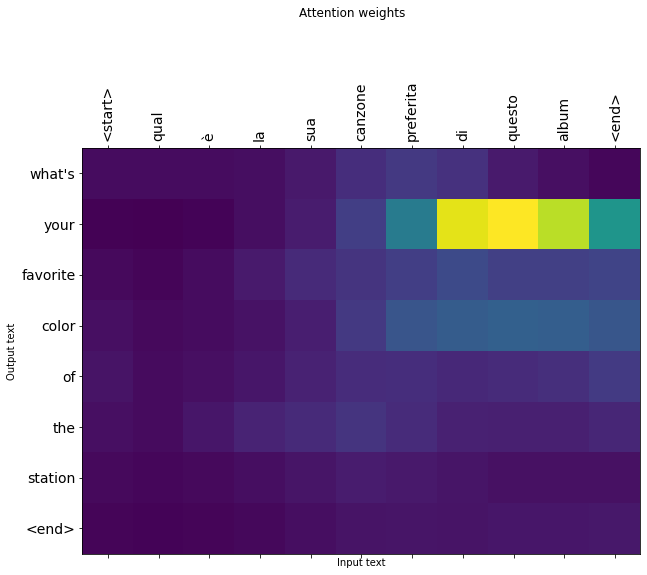

In [ ]:
" ".join(predict(test_encoder_padded[0], visualize_attention=True))

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
np.random.seed(101)
indexes = np.random.permutation(1000)
predicted_thousand_sentences = [" ".join(predict(test_encoder_padded[index], visualize_attention=False)) for index in indexes]
original_thousand_sentences = [X_test['english'].iloc[index] for index in indexes]

In [ ]:
import nltk.translate.bleu_score as bleu
avg_bleu = sum([bleu.sentence_bleu(reference, translated) for reference, translated in zip(original_thousand_sentences, predicted_thousand_sentences)]) / 1000
print(avg_bleu)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7859763326731088


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
tf.keras.backend.clear_session()

import os
import datetime

logdir = os.path.join("general_attention_encoder_decoder_tensorboard_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
params = dict()
params['input_vocab_size'] = vocab_size_encoder
params['encoder_embedding_dim'] = 100
params['lstm_size'] = 64
params['encoder_input_length'] = 20
params['scoring_function'] = 'general'
params['attention_units'] = 64

params['output_vocab_size'] = vocab_size_decoder_ip
params['decoder_embedding_dim'] = 100
params['decoder_input_length'] = 20

model = encoder_decoder(params)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_function, run_eagerly=True)

In [ ]:
!rm -rf general_attention_encoder_decoder_tensorboard_logs
# validation_data=([test_encoder_padded, test_decoder_padded_ip], test_decoder_padded_op)
model.fit([train_encoder_padded, train_decoder_padded_ip], train_decoder_padded_op, epochs=10, batch_size=64,
          validation_data=([test_encoder_padded, test_decoder_padded_ip], test_decoder_padded_op),
          callbacks=[tensorboard_callback])

Epoch 1/10
4416/4416 [==============================] - 2502s 536ms/step - loss: 0.3300 - val_loss: 0.2597
Epoch 2/10
4416/4416 [==============================] - 2294s 519ms/step - loss: 0.2217 - val_loss: 0.1935
Epoch 3/10
4416/4416 [==============================] - 2257s 511ms/step - loss: 0.1649 - val_loss: 0.1463
Epoch 4/10
4416/4416 [==============================] - 2221s 503ms/step - loss: 0.1258 - val_loss: 0.1194
Epoch 5/10
4416/4416 [==============================] - 2272s 514ms/step - loss: 0.1016 - val_loss: 0.1038
Epoch 6/10
4416/4416 [==============================] - 2277s 516ms/step - loss: 0.0862 - val_loss: 0.0937
Epoch 7/10
4416/4416 [==============================] - 2285s 517ms/step - loss: 0.0755 - val_loss: 0.0868
Epoch 8/10
4416/4416 [==============================] - 2243s 508ms/step - loss: 0.0673 - val_loss: 0.0824
Epoch 9/10
4416/4416 [==============================] - 2207s 500ms/step - loss: 0.0610 - val_loss: 0.0781
Epoch 10/10
4416/4416 [==============

General-bsaed attention:



1.   It is the multiplication between encoder output state and output of fully connected (Dense) layer of current decoder state.
2.   The shape of encoder output states is (batch_size, input_length, lstm_units).
3.   The shape of the decoder's current state is (batch_size, lstm_units).
4.   We add another dimension at axis=1 in the current decoder state to make the multiplication product easier.
5.   The softmax function passes the Multiplicative output to get attention weights.
6.   A context vector is calculated by the Sum Of Product (SOP) between encoder output states and attention weights.





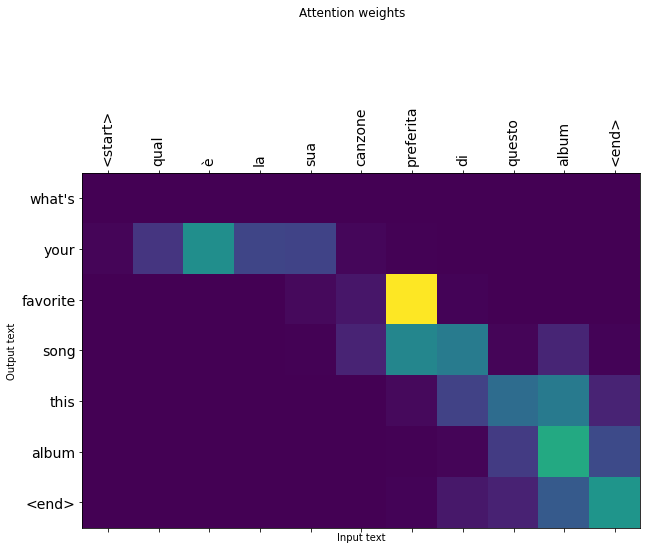

In [ ]:
predicted = " ".join(predict(test_encoder_padded[0], visualize_attention=True))

In [ ]:
np.random.seed(101)
indexes = np.random.permutation(1000)
predicted_thousand_sentences = [" ".join(predict(test_encoder_padded[index], visualize_attention=False)) for index in indexes]
original_thousand_sentences = [X_test['english'].iloc[index] for index in indexes]

In [ ]:
import nltk.translate.bleu_score as bleu
avg_bleu = sum([bleu.sentence_bleu(reference, translated) for reference, translated in zip(original_thousand_sentences, predicted_thousand_sentences)]) / 1000
print(avg_bleu)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.8407918975748012


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
tf.keras.backend.clear_session()

import os
import datetime

logdir = os.path.join("concat_attention_encoder_decoder_tensorboard_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
params = dict()
params['input_vocab_size'] = vocab_size_encoder
params['encoder_embedding_dim'] = 100
params['lstm_size'] = 64
params['encoder_input_length'] = 20
params['scoring_function'] = 'concat'
params['attention_units'] = 64

params['output_vocab_size'] = vocab_size_decoder_ip
params['decoder_embedding_dim'] = 100
params['decoder_input_length'] = 20

model = encoder_decoder(params)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_function, run_eagerly=True)

In [ ]:
!rm -rf concat_attention_encoder_decoder_tensorboard_logs
model.fit([train_encoder_padded, train_decoder_padded_ip], train_decoder_padded_op, epochs=10, batch_size=64,
          validation_data=([test_encoder_padded, test_decoder_padded_ip], test_decoder_padded_op),
          callbacks=[tensorboard_callback])

Epoch 1/10
4416/4416 [==============================] - 2559s 547ms/step - loss: 0.3178 - val_loss: 0.2529
Epoch 2/10
4416/4416 [==============================] - 2410s 546ms/step - loss: 0.2231 - val_loss: 0.1944
Epoch 3/10
4416/4416 [==============================] - 2378s 538ms/step - loss: 0.1698 - val_loss: 0.1508
Epoch 4/10
4416/4416 [==============================] - 2402s 544ms/step - loss: 0.1302 - val_loss: 0.1212
Epoch 5/10
4416/4416 [==============================] - 2383s 540ms/step - loss: 0.1036 - val_loss: 0.1035
Epoch 6/10
4416/4416 [==============================] - 2424s 549ms/step - loss: 0.0857 - val_loss: 0.0914
Epoch 7/10
4416/4416 [==============================] - 2378s 538ms/step - loss: 0.0734 - val_loss: 0.0830
Epoch 8/10
4416/4416 [==============================] - 2372s 537ms/step - loss: 0.0644 - val_loss: 0.0777
Epoch 9/10
4416/4416 [==============================] - 2402s 544ms/step - loss: 0.0576 - val_loss: 0.0734
Epoch 10/10
4416/4416 [==============

Concat-based attention:



1.   The summation of output between two dense layers (encoder output and current decoder state) is passed on to the tanh function, further passed via the third fully connected layer.
2.   The shape of encoder output states is (batch_size, input_length, lstm_units).
3.   The shape of the decoder's current state is (batch_size, lstm_units).
4.   We add another dimension at axis=1 in the current decoder state to make the multiplication product easier.
5.   The softmax function passes the fully connected output to get attention weights.
6. A context vector is calculated by the Sum Of Product (SOP) between encoder output states and attention weights.



In [ ]:
predicted = " ".join(predict(test_encoder_padded[0], visualize_attention=True))

In [ ]:
np.random.seed(101)
indexes = np.random.permutation(1000)
predicted_thousand_sentences = [" ".join(predict(test_encoder_padded[index], visualize_attention=False)) for index in indexes]
original_thousand_sentences = [X_test['english'].iloc[index] for index in indexes]

In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
avg_bleu = sum([bleu.sentence_bleu(reference, translated) for reference, translated in zip(original_thousand_sentences, predicted_thousand_sentences)]) / 1000
print(avg_bleu)

In [ ]:
# Write your observations on each of the scoring function

From the training observation, it looks like concat based attention performs better than comparing to general and dot-based. There is an apparent reason for that: Concat has more learning parameters, as it has a more dense layer. 